# Library

In [ ]:
pip install selectivesearch

In [ ]:
# Librerie standard
import os
import random
import time
import re
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.transforms import functional as TF

# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torchvision.models as models
from sklearn.svm import SVC

# Librerie per la gestione dei dati
import pandas as pd
import json
import orjson
import shutil 

# Librerie per il parallelismo e il multiprocessing
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

# Librerie per l'ottimizzazione e la gestione delle dipendenze
#import selectivesearch

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per la gestione dei dataset
from torch.utils.data import Dataset, DataLoader

# Librerie per modelli e trasformazioni in PyTorch
from torchvision import transforms

from collections import Counter
from sklearn.model_selection import train_test_split


# Path

In [ ]:
#Output folders and file names
OUT_COCO_JSON_NM = 'COCO_annotations_new.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')
cfg_fldr_pth = Path(f'/kaggle/input/our-xview-dataset/{OUT_CFG_FLDR_NM}')

coco_json_pth = in_dataset_pth / OUT_COCO_JSON_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'val.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

# PROPOSALS
OUT_PROPOSALS_FLDR_NM = 'proposals'
prop_fldr = Path(f'/kaggle/working/{OUT_PROPOSALS_FLDR_NM}')
PROP_COCO_JSON_NM = 'proposals.json'
proposals_json = out_dataset_pth / PROP_COCO_JSON_NM
ACTPROP_COCO_JSON_NM ='active_regions.json'
actproposals_json = out_dataset_pth / ACTPROP_COCO_JSON_NM
ACTPROP_WEIG_COCO_JSON_NM ='active_regions_weights.json'
actproposalsweights_json = out_dataset_pth / ACTPROP_WEIG_COCO_JSON_NM

# ACTIVE REGIONS
act_reg_path = Path('/kaggle/input/activeregion-xviewdataset')
act_reg_folder = Path('/kaggle/input/activeregion-xviewdataset/activeregion-xview-dataset/proposals')


#DATASET
train_path = '/kaggle/working/train.json'
test_path = '/kaggle/working/test.json'
val_path = '/kaggle/working/val.json'

random.seed(RANDOM_SEED)

In [ ]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)
clean_output(prop_fldr)

In [ ]:
import warnings

# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

# DataLoader

In [9]:
#numerosità iniziale categorie
from collections import defaultdict

# Carica il file JSON
with open(coco_json_pth, "r") as f:
    coco_data = json.load(f)

# Estrarre i dati principali
annotations = coco_data.get("annotations", [])
categories = coco_data.get("categories", [])

# Mappare id di categoria ai nomi delle categorie
category_id_to_name = {}
for category in categories:
    for cat_id, cat_name in category.items():  # Estrarre l'unico elemento dal dizionario
        category_id_to_name[int(cat_id)] = cat_name

# Contare i bounding box per categoria
bbox_counts = defaultdict(int)

for annotation in annotations:
    category_id = annotation["category_id"]
    bbox_counts[category_id] += 1

# Creare un elenco dei risultati
results = [
    (cat_id, category_id_to_name[cat_id], count)
    for cat_id, count in bbox_counts.items()
]

# Stampare i risultati
for cat_id, category_name, count in results:
    print(f"Categoria ID {cat_id} ('{category_name}'): {count} bounding box")


Categoria ID 6 ('Building'): 384947 bounding box
Categoria ID 1 ('Passenger Vehicle'): 225098 bounding box
Categoria ID 3 ('Railway Vehicle'): 4233 bounding box
Categoria ID 2 ('Truck'): 34379 bounding box
Categoria ID 0 ('Aircraft'): 1708 bounding box
Categoria ID 5 ('Engineering Vehicle'): 5473 bounding box
Categoria ID 8 ('Storage Tank'): 2033 bounding box
Categoria ID 9 ('Shipping Container'): 5391 bounding box
Categoria ID 4 ('Maritime Vessel'): 6329 bounding box
Categoria ID 10 ('Pylon'): 470 bounding box
Categoria ID 7 ('Helipad'): 152 bounding box


## Region Proposals Generation

In [ ]:
# Funzione per elaborare una singola immagine
def process_single_image(image_data, img_fldr):
    img_id = image_data['id']
    img_name = image_data['file_name']
    img_path = os.path.join(img_fldr, img_name)

    if not os.path.exists(img_path):
        raise ValueError(f"Immagine non trovata nel percorso: {img_path}")

    # Carica l'immagine usando opencv (in modalità RGB)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti in RGB
    original_height, original_width, _ = image.shape

    # Ridimensiona l'immagine per velocizzare la Selective Search
    resized_image = cv2.resize(image, (original_width // 2, original_height // 2), interpolation=cv2.INTER_AREA)

    # Genera le region proposals sulla versione ridotta
    processed_proposals = generate_and_process_proposals(resized_image, original_width // 2, original_height // 2)

    # Riscalare le coordinate delle proposte alla dimensione originale
    scaled_proposals = [[x * 2, y * 2, x_max * 2, y_max * 2] for x, y, x_max, y_max in processed_proposals]

    image_data = {
        "image_id": img_id,
        "file_name": img_name,
        "original_size": [original_width, original_height],
        "proposals": []
    }

    for i, proposal in enumerate(scaled_proposals):
        x_min, y_min, x_max, y_max = proposal
        image_data["proposals"].append({
            "proposal_id": i,
            "coordinates": [x_min, y_min, x_max, y_max]
        })

    return image_data

In [ ]:
# Funzione per generare le region proposals con Selective Search
def generate_and_process_proposals(image, img_width, img_height):
    img_np = np.array(image, dtype=np.uint8)

    # Esegui la selective search con parametri ottimizzati
    _, regions = selectivesearch.selective_search(img_np, scale=300, sigma=0.8, min_size=20)

    if len(regions) == 0:
        print(f"Warning: Nessuna regione proposta generata per immagine con forma {img_np.shape}.")

    processed_proposals = []

    # Pre-filtraggio delle regioni
    for region in regions:
        x, y, w, h = region['rect']
        area = w * h
        if w >= 10 and h >= 10 and 10 <= area <= 0.8 * (img_width * img_height):
            x_max, y_max = x + w, y + h
            processed_proposals.append([x, y, x_max, y_max])

    return processed_proposals

In [ ]:
# Funzione per gestire i batch
def batch(iterable, n=1):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk:
            break
        yield chunk

In [ ]:
def generate_dataset_proposals(coco_json, img_fldr, output_dir, output_json):
    os.makedirs(output_dir, exist_ok=True)
    all_image_data = []

    # Carica il file JSON di COCO
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    # Prepara il mapping delle annotazioni per le immagini
    image_annotations_map = {}
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        if image_id not in image_annotations_map:
            image_annotations_map[image_id] = []
        image_annotations_map[image_id].append(annotation)

    images_with_annotations = [
        image_data for image_data in coco_data['images']
        if image_data['id'] in image_annotations_map and len(image_annotations_map[image_data['id']]) > 0
    ]

    # Parametri per parallelizzazione e batch processing
    max_workers = os.cpu_count() - 1
    batch_size = 500
    total_batches = len(images_with_annotations) // batch_size + (len(images_with_annotations) % batch_size > 0)

    # Processa le immagini in batch con tqdm per monitorare il progresso dei batch
    with tqdm(total=total_batches, desc="Processing batches") as pbar:
        for image_batch in batch(images_with_annotations, batch_size):
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(process_single_image, image_batch, [img_fldr] * len(image_batch)))
            all_image_data.extend(results)
            pbar.update(1)  # Aggiorna la barra di progresso per ogni batch completato

    # Salva il risultato in formato JSON usando orjson
    with open(output_json, 'wb') as json_file:
        json_file.write(orjson.dumps(all_image_data, option=orjson.OPT_INDENT_2))

    print(f"Creato file JSON con le region proposals: {output_json}")

In [ ]:
generate_dataset_proposals(coco_json_pth, img_fldr, prop_fldr, proposals_json)

## Positive Region Proposals

In [ ]:
ignored_count = 0  # Contatore globale per le regioni ignorate

def get_iou(bb1, bb2):
    global ignored_count  # Accedi alla variabile globale del contatore

    try:
        # Assicurati che le dimensioni siano corrette
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        # Se si verifica un errore, incrementa il contatore delle regioni ignorate
        ignored_count += 1
        return 0.0  # Restituisci 0.0 per l'IoU in caso di errore (nessuna sovrapposizione)

    # Calcola le dimensioni dell'area comune tra i due box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Se non c'è sovrapposizione, restituisci 0 come area di intersezione
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calcola l'area di intersezione
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calcola le aree individuali dei due bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # Calcola l'area dell'unione
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Verifica che l'IoU sia nel range corretto
    assert iou >= 0.0
    assert iou <= 1.0

    return iou

In [ ]:
def assign_and_save_regions(region_json_path, bbox_json_path, image_dir, output_dir, output_json_path, iou_threshold=0.5):
    """Associa le regioni proposte ai bounding boxes, salva le regioni positive come immagini e crea un nuovo JSON con informazioni attivate."""
    
    # Carica i file JSON
    with open(region_json_path, 'r') as f:
        regions = json.load(f)

    with open(bbox_json_path, 'r') as f:
        bboxes = json.load(f)
    
    # Crea un dizionario per cercare annotations per image_id
    annotations_by_image = {}
    for annot in bboxes["annotations"]:
        img_id = annot["image_id"]
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        # Converte il campo bbox da stringa a lista di float e poi in formato [x1, y1, x2, y2]
        bbox = json.loads(annot["bbox"])  # Converte la stringa in una lista di numeri
        x, y, w, h = bbox
        bbox_converted = [x, y, x + w, y + h]  # Converti in [x1, y1, x2, y2]
        annotations_by_image[img_id].append((torch.tensor(bbox_converted, dtype=torch.float32), annot["category_id"]))
    
    # Crea un dizionario per mappare category_id ai nomi delle categorie
    category_mapping = {cat_id: name for cat_id, name in enumerate(bboxes["categories"])}
    
    # Crea la directory di output se non esiste
    os.makedirs(output_dir, exist_ok=True)

    counter = 0  # Contatore delle immagini salvate
    
    active_region_data = []  # Lista per i dati delle regioni attive

    # Avvolgi il ciclo principale per ogni immagine con tqdm (una barra di progresso generale)
    for image in tqdm(regions, desc="Elaborazione immagini", total=len(regions)):
        image_id = image["image_id"]
        file_name = image["file_name"]
        proposals = image["proposals"]
        
        # Ottieni bounding boxes ground-truth e categorie per l'immagine corrente
        gt_data = annotations_by_image.get(image_id, [])
        if not gt_data:
            # Se non ci sono bounding boxes ground-truth, salta l'immagine
            continue
        
        gt_bboxes = [item[0] for item in gt_data]  # Bounding box ground truth
        gt_categories = [item[1] for item in gt_data]  # Categorie ground truth
        
        # Trasforma proposals in una lista di dizionari compatibili con get_iou
        proposal_coords = [{'x1': p["coordinates"][0], 'y1': p["coordinates"][1], 
                            'x2': p["coordinates"][2], 'y2': p["coordinates"][3]} 
                           for p in proposals]
        
        # Calcola la matrice IoU usando la funzione get_iou
        iou_matrix = []
        for proposal in proposal_coords:
            iou_row = []
            for gt_bbox in gt_bboxes:
                # Ogni gt_bbox deve essere un dizionario simile a proposal
                gt_dict = {'x1': gt_bbox[0].item(), 'y1': gt_bbox[1].item(), 
                           'x2': gt_bbox[2].item(), 'y2': gt_bbox[3].item()}
                iou = get_iou(proposal, gt_dict)
                iou_row.append(iou)
            iou_matrix.append(iou_row)

        # Verifica se la matrice IoU è vuota (ad esempio, se non ci sono bounding box ground-truth per un'immagine, allora gt_bboxes è vuoto)
        if not iou_matrix:
            continue
        
        iou_matrix = torch.tensor(iou_matrix)

        # Identifica le regioni positive (IoU >= soglia)
        max_ious, indices = torch.max(iou_matrix, dim=1)
        positive_indices = torch.nonzero(max_ious >= iou_threshold).squeeze(1)
        
        # Carica l'immagine originale
        image_path = os.path.join(image_dir, file_name)
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Immagine non trovata: {image_path}")
            continue
        
        # Avvolgi il ciclo per ogni proposta positiva senza tqdm (non serve più una barra per ogni proposta)
        for idx in positive_indices:
            x_min, y_min, x_max, y_max = proposal_coords[idx].values()

            # Calcola la larghezza e l'altezza per il formato COCO
            width = x_max - x_min
            height = y_max - y_min
            
            cropped = original_image[int(y_min):int(y_max), int(x_min):int(x_max)]
            
            # Ridimensiona a 224x224
            resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_AREA)
            
            # Ottieni l'etichetta della categoria dal bounding box assegnato
            category_id = gt_categories[indices[idx].item()]
            
            # Salva l'immagine
            output_path = os.path.join(output_dir, f"image_{counter:06d}.jpg")
            cv2.imwrite(output_path, resized)
            
            # Aggiungi la proposta attivata al nuovo JSON in formato COCO
            active_region_data.append({
                "image_id": image_id,
                "file_name": file_name,
                "category_id": category_id,
                "proposal_id": idx.item(),
                "region_bbox": [x_min, y_min, width, height],  
                "saved_path": output_path
            })
            
            counter += 1
    
    # Salva il nuovo JSON con le regioni attive
    with open(output_json_path, 'w') as json_file:
        json.dump(active_region_data, json_file, indent=2)

In [ ]:
assign_and_save_regions(proposals_json, coco_json_pth, img_fldr, prop_fldr, actproposals_json, iou_threshold=0.5)

In [ ]:
print(ignored_count)

In [58]:
# controllo sulle regioni
file_path = '/kaggle/input/activeregion-xviewdataset/activeregion-xview-dataset/active_regions.json'

#carica il file JSON
with open(file_path, 'r') as f:
    data = json.load(f)

#conta numero di regioni
num_regioni = len(data)
print(f"Numero di regioni: {num_regioni}")

# occorrenze dei category_id
category_ids = [entry['category_id'] for entry in data]
category_counts = Counter(category_ids)
print("Occorrenze dei category_id:", category_counts)


Numero di regioni: 180600
Occorrenze dei category_id: Counter({6: 159041, 1: 6132, 9: 3563, 4: 3488, 2: 2765, 0: 2731, 5: 1226, 8: 1159, 3: 329, 10: 98, 7: 68})


In [ ]:
import zipfile
import os

working_dir = "/kaggle/working"

# Nome del file zip da creare
zip_file_name = "activeregion-xview-dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "active_regions.json",
    "proposals",
    "proposals.json"
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, working_dir)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

# Active Regions con pesi

In [ ]:
ignored_count = 0  # Contatore globale per le regioni ignorate

def get_iou(bb1, bb2, class_id, class_frequencies, iou_threshold_default=0.5):
    """
    Calcola l'IoU (Intersection over Union) tra due bounding box e applica una soglia IoU dinamica
    in base alla frequenza della classe.
    
    :param bb1: Bounding box proposto
    :param bb2: Bounding box di verità a terra
    :param class_id: ID della classe associata al bounding box
    :param class_frequencies: Frequenza di ciascuna classe nel dataset
    :param iou_threshold_default: Soglia IoU di base
    :return: IoU tra i due bounding box
    """
    global ignored_count  # Accedi alla variabile globale del contatore

    # Verifica le dimensioni dei bounding box
    try:
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        ignored_count += 1  # Incrementa il contatore delle regioni ignorate
        return 0.0  # Restituisci 0.0 in caso di errore (nessuna sovrapposizione)

    # Calcola la soglia IoU dinamica per la classe
    class_weight = 1 / (class_frequencies[class_id] + 1e-6)  # Inversamente proporzionale alla frequenza
    iou_threshold = iou_threshold_default + (1 - class_weight) * 0.3  # Modifica la soglia IoU per classi rare
    
    # Calcola l'area di intersezione tra i due bounding box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    # Se non c'è sovrapposizione, restituisce 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Area di intersezione
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Area di ciascun bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # Calcolare l'area di unione
    union_area = bb1_area + bb2_area - intersection_area
    
    # Calcolare IoU
    iou = intersection_area / float(union_area)
    
    # Se l'IoU supera la soglia dinamica, la regione è considerata attiva
    if iou >= iou_threshold:
        return iou
    else:
        return 0.0

In [ ]:
def assign_and_save_regions(region_json_path, bbox_json_path, image_dir, output_dir, output_json_path, iou_threshold_default=0.5):
    """Associa le regioni proposte ai bounding boxes, salva le regioni positive come immagini e crea un nuovo JSON con informazioni attivate."""
    
    # Carica i file JSON delle regioni proposte e dei bounding box
    with open(region_json_path, 'r') as f:
        regions = json.load(f)

    with open(bbox_json_path, 'r') as f:
        bboxes = json.load(f)
    
    # Crea un dizionario per cercare annotations per image_id
    annotations_by_image = {}
    for annot in bboxes["annotations"]:
        img_id = annot["image_id"]
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        # Converte il campo bbox da stringa a lista di float e poi in formato [x1, y1, x2, y2]
        bbox = json.loads(annot["bbox"])  # Converte la stringa in una lista di numeri
        x, y, w, h = bbox
        bbox_converted = [x, y, x + w, y + h]  # Converti in [x1, y1, x2, y2]
        annotations_by_image[img_id].append((torch.tensor(bbox_converted, dtype=torch.float32), annot["category_id"]))
    
    # Crea un dizionario per mappare category_id ai nomi delle categorie
    category_mapping = {cat_id: name for cat_id, name in enumerate(bboxes["categories"])}
    
    # Calcola la frequenza delle classi
    class_frequencies = Counter([annot["category_id"] for annot in bboxes["annotations"]])
    
    # Crea la directory di output se non esiste
    os.makedirs(output_dir, exist_ok=True)

    counter = 0  # Contatore delle immagini salvate
    
    active_region_data = []  # Lista per i dati delle regioni attive

    # Avvolgi il ciclo principale per ogni immagine con tqdm (una barra di progresso generale)
    for image in tqdm(regions, desc="Elaborazione immagini", total=len(regions)):
        image_id = image["image_id"]
        file_name = image["file_name"]
        proposals = image["proposals"]
        
        # Ottieni bounding boxes ground-truth e categorie per l'immagine corrente
        gt_data = annotations_by_image.get(image_id, [])
        if not gt_data:
            # Se non ci sono bounding boxes ground-truth, salta l'immagine
            continue
        
        gt_bboxes = [item[0] for item in gt_data]  # Bounding box ground truth
        gt_categories = [item[1] for item in gt_data]  # Categorie ground truth
        
        # Trasforma proposals in una lista di dizionari compatibili con get_iou
        proposal_coords = [{'x1': p["coordinates"][0], 'y1': p["coordinates"][1], 
                            'x2': p["coordinates"][2], 'y2': p["coordinates"][3]} 
                           for p in proposals]
        
        # Calcola la matrice IoU usando la funzione get_iou con soglia dinamica
        iou_matrix = []
        for proposal in proposal_coords:
            iou_row = []
            for gt_bbox, gt_class_id in zip(gt_bboxes, gt_categories):
                # Ogni gt_bbox deve essere un dizionario simile a proposal
                gt_dict = {'x1': gt_bbox[0].item(), 'y1': gt_bbox[1].item(), 
                           'x2': gt_bbox[2].item(), 'y2': gt_bbox[3].item()}
                iou = get_iou(proposal, gt_dict, gt_class_id, class_frequencies)
                iou_row.append(iou)
            iou_matrix.append(iou_row)

        # Verifica se la matrice IoU è vuota (ad esempio, se non ci sono bounding box ground-truth per un'immagine, allora gt_bboxes è vuoto)
        if not iou_matrix:
            continue
        
        iou_matrix = torch.tensor(iou_matrix)

        # Identifica le regioni positive (IoU >= soglia)
        max_ious, indices = torch.max(iou_matrix, dim=1)
        positive_indices = torch.nonzero(max_ious >= iou_threshold_default).squeeze(1)
        
        # Carica l'immagine originale
        image_path = os.path.join(image_dir, file_name)
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Immagine non trovata: {image_path}")
            continue
        
        # Avvolgi il ciclo per ogni proposta positiva
        for idx in positive_indices:
            x_min, y_min, x_max, y_max = proposal_coords[idx].values()

            # Calcola la larghezza e l'altezza per il formato COCO
            width = x_max - x_min
            height = y_max - y_min
            
            cropped = original_image[int(y_min):int(y_max), int(x_min):int(x_max)]
            
            # Ridimensiona a 224x224
            resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_AREA)
            
            # Ottieni l'etichetta della categoria dal bounding box assegnato
            category_id = gt_categories[indices[idx].item()]
            
            # Salva l'immagine
            output_path = os.path.join(output_dir, f"image_{counter:06d}.jpg")
            cv2.imwrite(output_path, resized)
            
            # Aggiungi la proposta attivata al nuovo JSON in formato COCO
            active_region_data.append({
                "image_id": image_id,
                "file_name": file_name,
                "category_id": category_id,
                "proposal_id": idx.item(),
                "region_bbox": [x_min, y_min, width, height],  
                "saved_path": output_path
            })
            
            counter += 1
    
    # Salva il nuovo JSON con le regioni attive
    with open(output_json_path, 'w') as json_file:
        json.dump(active_region_data, json_file, indent=2)

In [ ]:
assign_and_save_regions(proposals_json, coco_json_pth, img_fldr, prop_fldr, actproposalsweights_json, iou_threshold_default=0.5)

# Splitting

In [4]:
# Percorso del file JSON e del percorso base
input_json_path = "/kaggle/input/activeregion-xviewdataset/activeregion-xview-dataset/active_regions.json"

# Carica il dataset dal JSON
with open(input_json_path, "r") as f:
    data = json.load(f)

# Converti in DataFrame per una gestione più comoda
df = pd.DataFrame(data)

# Estrai il nome del file dal campo 'saved_path'
df["file_name"] = df["saved_path"].apply(lambda x: os.path.basename(x))

# Aggiungi il percorso base al campo 'saved_path'
df["saved_path"] = df["file_name"].apply(lambda x: str(act_reg_folder / x))

# Estrai i dati e le etichette
X = df.index  # Indici delle righe
y = df["category_id"]  # Etichetta per stratificazione

# Step 1: Train + Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Val/Test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Creazione dei dataset finali
train_data = df.loc[X_train]
val_data = df.loc[X_val]
test_data = df.loc[X_test]

# Salva i dataset in nuovi file JSON
train_data.to_json("train.json", orient="records", lines=False)
val_data.to_json("val.json", orient="records", lines=False)
test_data.to_json("test.json", orient="records", lines=False)

print("Splitting completato. File salvati: train.json, val.json, test.json.")

Splitting completato. File salvati: train.json, val.json, test.json.


## Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, json_file, transform=None):
        """
        Inizializza il dataset.

        :param json_file: Percorso del file JSON contenente le informazioni sulle regioni.
        :param transform: Trasformazioni da applicare alle immagini. Se non fornito, vengono usate trasformazioni di default.
        """
        with open(json_file, 'r') as f:
            self.data = json.load(f)  # Carica il file JSON
        
        # Trasformazioni di default se non vengono fornite
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),         # Ridimensiona l'immagine a 224x224
            transforms.ToTensor()                 # Converte l'immagine in un tensore
            #transforms.Normalize(                  # Normalizzazione con valori di ImageNet
            #    mean=[0.485, 0.456, 0.406], 
            #    std=[0.229, 0.224, 0.225]
            #)
        ])  

    def __len__(self):
        """Restituisce il numero totale di immagini/proposte nel dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Restituisce un esempio (immagine e etichetta) per l'addestramento."""
        # Carica l'esempio dal file JSON
        sample = self.data[idx]
        
        # Carica l'immagine
        image = Image.open(sample["saved_path"]).convert("RGB")
        
        # Etichetta della categoria
        label = sample["category_id"]  # Categoria della proposta

        # Applica le trasformazioni
        image = self.transform(image)
        
        return image, label

In [6]:
test_ds = CustomDataset(test_path)
train_ds = CustomDataset(train_path)
val_ds = CustomDataset(val_path)

TrainLoader = DataLoader(train_ds, batch_size=64, shuffle=True)
ValLoader = DataLoader(val_ds, batch_size=64, shuffle=False)
TestLoader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Feature Extraction

In [15]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self._output_num = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
     
        self.drop8 = nn.Dropout()
        self.fn8 = nn.Linear(256 * 6 * 6, 4096)
        self.active8 = nn.ReLU(inplace=True)
        
        self.drop9 = nn.Dropout()
        self.fn9 = nn.Linear(4096, 4096)
        self.active9 = nn.ReLU(inplace=True)
        
        self.fn10 = nn.Linear(4096, self._output_num)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.drop8(x)
        x = self.fn8(x)
        x = self.active8(x)

        x = self.drop9(x)
        x = self.fn9(x)
        
        feature = self.active9(x)  
        #final = func.sigmoid(self.fn10(feature))
        final = self.fn10(feature)

        return feature, final

In [41]:
num_classes = 12 #11 classi + sfondo
net = AlexNet(num_classes)

In [42]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (drop8): Dropout(p=0.5, inplace=False)
  (fn8): Linear(in_features=9216, out_features=4096, bias=True)
  (active8): ReLU(inplace=T

In [27]:
def plot_loss(train_losses, val_losses):
    """
    Funzione per fare il plot della funzione di loss durante il training e la validazione.

    :param train_losses: Lista delle perdite durante il training.
    :param val_losses: Lista delle perdite durante la validazione.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle='-', marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", linestyle='-', marker='x')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
def compute_class_weights(train_loader, num_classes=12, background_weight=2.0):
    """
    Calcola i pesi per ciascuna classe nel dataset in base alla frequenza delle etichette,
    includendo un peso per la classe "sfondo" (ID=11) che potrebbe non essere presente nei dati.

    :param train_loader: DataLoader per il training set.
    :param num_classes: Numero totale di classi nel dataset (incluso lo sfondo).
    :param background_weight: Peso assegnato alla classe "sfondo" (ID=11).
    :return: Tensor dei pesi per ciascuna classe.
    """
    # Estrai tutte le etichette dal dataset nel train_loader
    all_labels = []
    for _, labels in tqdm(train_loader, desc="Estrazione etichette", leave=False):
        all_labels.extend(labels.numpy())  # Estrae le etichette dalle immagini

    # Conta le occorrenze di ciascuna classe
    class_counts = Counter(all_labels)
    
    # Calcola il peso per ogni classe (inversamente proporzionale alla frequenza)
    total_samples = len(all_labels)
    class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}
    
    # Normalizza i pesi (in modo che il peso massimo sia 1)
    max_weight = max(class_weights.values())
    normalized_weights = {class_id: weight / max_weight for class_id, weight in class_weights.items()}
    
    # Aggiungi un peso elevato per la classe sfondo (ID=11)
    normalized_weights[11] = background_weight  # Assegna un peso maggiore alla classe sfondo
    
    # Crea un tensor dei pesi, dove ogni peso corrisponde alla classe
    weights = torch.tensor([normalized_weights.get(i, 1.0) for i in range(num_classes)], dtype=torch.float32)
    
    return weights

In [49]:
def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs, path_min_loss, class_weights):
    """
    Funzione per addestrare il modello con pesi per classi sbilanciate.

    :param net: Modello da addestrare.
    :param train_loader: DataLoader per il training set.
    :param val_loader: DataLoader per il validation set.
    :param criterion: Funzione di loss.
    :param optimizer: Ottimizzatore.
    :param device: Dispositivo (CPU o GPU).
    :param epochs: Numero di epoche di training.
    :param path_min_loss: Percorso per salvare il modello con la minore loss di validazione.
    """
    min_val_loss = float('inf')

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Liste per registrare le perdite durante il training e la validazione
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        net.train()  # Modalità training
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Barra di avanzamento per il training
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss pesata
            loss = criterion(outputs, labels)

            # Backward pass e aggiornamento pesi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistiche
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Aggiorna la barra di avanzamento con la loss corrente
            train_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(avg_train_loss)  # Aggiungi il valore di train_loss

        # Validazione
        net.eval()  # Modalità validazione
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Barra di avanzamento per la validazione
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                _, outputs = net(images)

                # Calcolo della loss
                loss = criterion(outputs, labels)

                # Statistiche
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                # Aggiorna la barra di avanzamento con la loss e accuracy
                val_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(avg_val_loss)  # Aggiungi il valore di val_loss

        # Salva il modello con la loss di validazione più bassa
        if avg_val_loss < min_val_loss:
            print(f"Salvataggio del miglior modello: Val Loss migliorata da {min_val_loss:.4f} a {avg_val_loss:.4f}")
            min_val_loss = avg_val_loss
            torch.save(net.state_dict(), path_min_loss)

        # Stampa statistiche per epoca
        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    print("Training completato!")

    # Chiamata alla funzione per tracciare il grafico
    plot_loss(train_losses, val_losses)

In [11]:
def test_model(net, test_loader, criterion, device, path_min_loss):
    """
    Funzione per testare il modello.

    :param net: Modello da testare.
    :param test_loader: DataLoader per il test set.
    :param criterion: Funzione di loss.
    :param device: Dispositivo (CPU o GPU).
    :param path_min_loss: Percorso del modello salvato.
    """
    # Carica il miglior modello salvato
    net.load_state_dict(torch.load(path_min_loss))
    net.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss
            loss = criterion(outputs, labels)

            # Statistiche
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct_test / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


In [52]:
# Calcola i pesi per ogni classe dal train_loader
class_weights = compute_class_weights(TrainLoader)
print(class_weights)

tensor([2.4714e-02, 1.1007e-02, 2.4412e-02, 2.0532e-01, 1.9355e-02, 5.5046e-02,
        4.2442e-04, 1.0000e+00, 5.8252e-02, 1.8941e-02, 6.9231e-01, 1.0000e+01])


In [53]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device("cuda")

net = net.to(device)
criterion = criterion.to(device)

path_min_loss = '/kaggle/working/AlexNet.pth'

train_model(
    net=net,
    train_loader=TrainLoader,
    val_loader=ValLoader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    path_min_loss=path_min_loss,
    class_weights=class_weights
)

Salvataggio del miglior modello: Val Loss migliorata da inf a 2.3046
Epoch [1/10]
Train Loss: 2.3292, Train Accuracy: 38.88%
Val Loss: 2.3046, Val Accuracy: 1.93%


Salvataggio del miglior modello: Val Loss migliorata da 2.3046 a 2.3041
Epoch [2/10]
Train Loss: 2.2994, Train Accuracy: 74.01%
Val Loss: 2.3041, Val Accuracy: 88.06%


Salvataggio del miglior modello: Val Loss migliorata da 2.3041 a 2.2992
Epoch [3/10]
Train Loss: 2.2980, Train Accuracy: 69.21%
Val Loss: 2.2992, Val Accuracy: 88.06%


KeyboardInterrupt: 

In [55]:
test_model(
    net=net,
    test_loader=TestLoader,
    criterion=criterion,
    device=device,
    path_min_loss=path_min_loss
)

/tmp/ipykernel_23/2639019227.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path_min_loss))


Test Loss: 2.1012, Test Accuracy: 88.06%


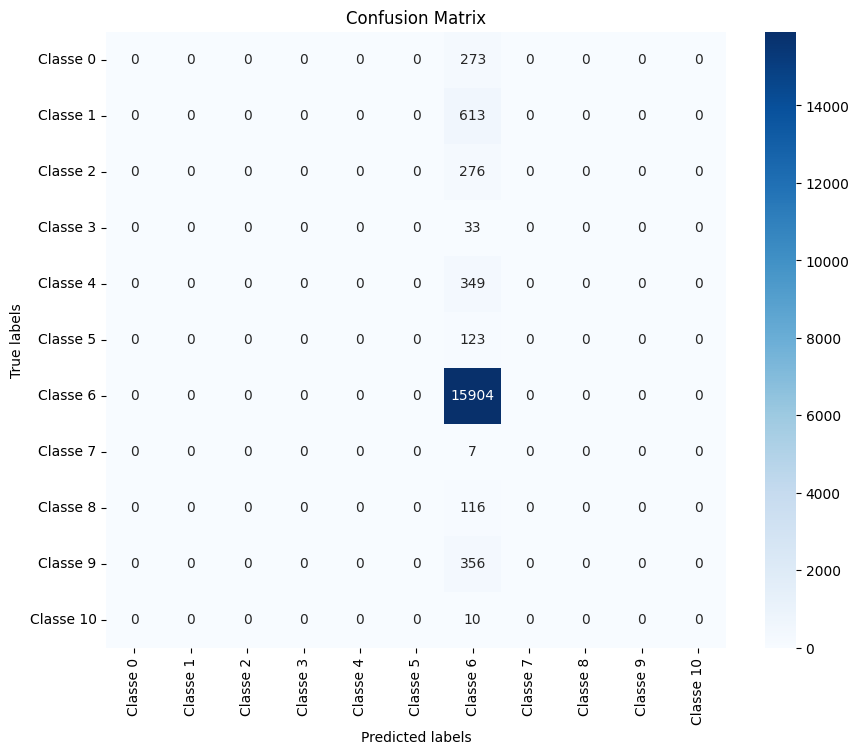

In [57]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Funzione per calcolare e visualizzare la matrice di confusione.

    :param y_true: Etichette reali
    :param y_pred: Etichette predette dal modello
    :param class_names: Nomi delle classi
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Durante la fase di validazione o test, calcola la matrice di confusione
def validate_model(net, val_loader, device, class_names):
    net.eval()  # Modalità di valutazione
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            _, outputs = net(images)
            
            # Predizioni
            _, predicted = outputs.max(1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Visualizza la matrice di confusione
    plot_confusion_matrix(all_labels, all_preds, class_names)

# Esempio di come chiamare la funzione
class_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5', 'Classe 6', 'Classe 7', 'Classe 8', 'Classe 9', 'Classe 10']
validate_model(net, ValLoader, device, class_names)